<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/05.trees-and-ensembles/05.trees-and-ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

from collections import Counter

from imblearn.over_sampling import SMOTE


# Import the visualization library I prepared for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat, plot_feature_importances


!pip install ipython-autotime # To show time at each cell
                              # Credits to https://medium.com/@arptoth/how-to-measure-execution-time-in-google-colab-707cc9aad1c8
%load_ext autotime


# The following is to be able to mount Google Drive
from google.colab import drive

import pickle # To save the model
from os.path import isfile

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


--2020-12-08 19:22:56--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]  12.70K  --.-KB/s    in 0s      

2020-12-08 19:22:57 (76.3 MB/s) - ‘visualization.py’ saved [13008/13008]

time: 330 µs


Mount Google Drive

In [3]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/05.trees/'

Mounted at /content/gdrive
time: 21.2 s


# Use case and dataset

We use the dataset by [Reyhane Askari Hemmat](https://github.com/ReyhaneAskari/SLA_violation_classification) (Université de Montréal) used in [He16]. This dataset is built from [Google Cloud Cluster Trace](https://github.com/google/cluster-data), a 29-days trace of activity in a Google Cloud cluster. The trace reports:

* Resources available on the machines
* Tasks submitted by users, along with the requested resources
* Actual resources used by tasks
* Events, like eviction of tasks (for lack of resources, failure of the machine, etc.)


Hemmat et Al. [He16] pre-processed this trace:
* For each submitted task, they checked if the task correctly terminates or is evicted
* They created as csv file with the task characteristics and a `violation` column, to indicating failure (1) or normal termination (0).


### Goal
Predict a task failure, i.e., whether a task [will be evicted](https://github.com/ReyhaneAskari/SLA_violation_classification/blob/55bba2683dec43e739244b6b616294827a98f8e1/3_create_database/scripts/full_db_2.py#L33) before normal termination. 

In [4]:
!wget https://raw.githubusercontent.com/ReyhaneAskari/SLA_violation_classification/master/3_create_database/csvs/frull_db_2.csv

--2020-12-08 19:24:25--  https://raw.githubusercontent.com/ReyhaneAskari/SLA_violation_classification/master/3_create_database/csvs/frull_db_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10633997 (10M) [text/plain]
Saving to: ‘frull_db_2.csv’

frull_db_2.csv      100%[===================>]  10.14M  49.3MB/s    in 0.2s    

2020-12-08 19:24:26 (49.3 MB/s) - ‘frull_db_2.csv’ saved [10633997/10633997]

time: 924 ms


Unfortunately, [no GPU support](https://stackoverflow.com/a/41568439/2110769) is available for scikit learn.

# Load dataset and preliminary operations


In [5]:
train_path = "frull_db_2.csv"
df = pd.read_csv(train_path)
df

,Unnamed: 0,job_id,task_idx,sched_cls,priority,cpu_requested,mem_requested,disk,violation
0,2,3418314,0,3,9,0.12500,0.074460,0.000424,0
1,3,3418314,1,3,9,0.12500,0.074460,0.000424,0
2,45,3418368,0,3,9,0.03125,0.086910,0.000455,0
3,46,3418368,1,3,9,0.03125,0.086910,0.000455,0
4,47,3418368,2,3,9,0.03125,0.086910,0.000455,0
...,...,...,...,...,...,...,...,...,...
201195,450131,6251995937,196,0,0,0.06873,0.011930,0.000115,0
201196,450134,4392480606,180,2,0,0.06250,0.063350,0.000077,0
201197,450137,5285926325,0,0,9,0.06250,0.006218,0.000038,1
201198,450142,6183750753,60,1,0,0.12500,0.033390,0.000019,0


time: 229 ms


Column description:
* `job_id`: users submit jobs, i.e., a set of tasks
* `task_idx`: the index of a task within a job. A task is uniquely identified by `(job_id, task_idx)`
* `sched_cls`: From [Re11]: "3 representing a more latency-sensitive task (e.g., serving revenue-generating user requests) and 0 representing a non-production task (e.g., development, non-business-critical analyses, etc.)... more latency-sensitive tasks tend to have higher task priorities"
* `priority`
* `cpu_requested`: Maximum amount of CPU the task is permitted to use. 
  * Unit of measurement: core-count / second.
  * The scale is relateive to the CPU available in the most powerful machine of the cluster.
  * This is specified by the user at submission time
* `mem_requested`: Maximum amount of memory the task is permitted to use. 
  * Unit of measurement: GB
  * The scale is relateive to the memory available in the machine of the cluster with the largest memory.
  * This is specified by the user at submission time
* `disk`: Similarly to `mem_requested`

We need to remove features that have no predictive meaning

In [6]:
df = df.drop(labels=['Unnamed: 0', 'job_id', 'task_idx'], axis=1)
df

,sched_cls,priority,cpu_requested,mem_requested,disk,violation
0,3,9,0.12500,0.074460,0.000424,0
1,3,9,0.12500,0.074460,0.000424,0
2,3,9,0.03125,0.086910,0.000455,0
3,3,9,0.03125,0.086910,0.000455,0
4,3,9,0.03125,0.086910,0.000455,0
...,...,...,...,...,...,...
201195,0,0,0.06873,0.011930,0.000115,0
201196,2,0,0.06250,0.063350,0.000077,0
201197,0,9,0.06250,0.006218,0.000038,1
201198,1,0,0.12500,0.033390,0.000019,0


time: 29.9 ms


Let's partition the dataset in training and test dataset

In [7]:
X = df.drop(labels='violation', axis=1)
y = df['violation']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, 
                                        shuffle=True, random_state=4)

time: 33.1 ms


Check for class imbalance and correct for it

In [8]:
print( "Samples per class before SMOTE: ", Counter(y_train) )

smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)

print( "Samples per class after SMOTE: ", Counter(y_train) )

Samples per class before SMOTE:  Counter({0: 129445, 1: 11395})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Samples per class after SMOTE:  Counter({0: 129445, 1: 129445})
time: 1 s


# Training and testing a random forest

In [9]:
model = RandomForestClassifier(n_estimators=100, 
                      criterion='gini', 
                      max_leaf_nodes=16, # Each tree cannot have more than that
                      random_state=5, # For reproducibility
                      n_jobs=-1, # Use all the CPUs
                      max_features = 'auto' # auto means=sqrt(n_features)
                      )

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

time: 7.7 s


Normalized confusion matrix
[[0.90304165 0.09695835]
 [0.10908715 0.89091285]]


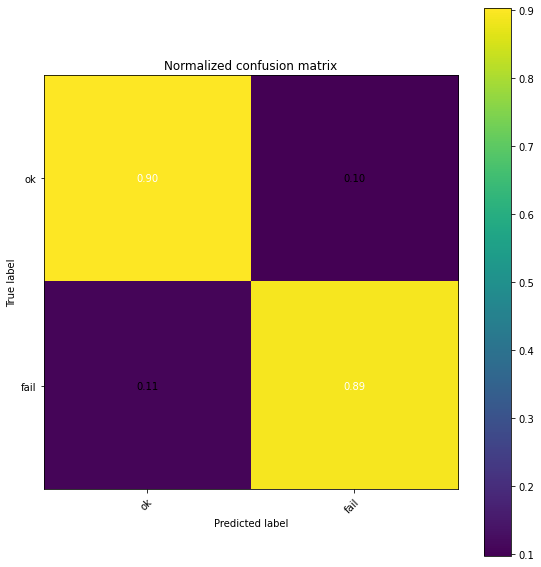

time: 691 ms


In [10]:
y_pred = model.predict(X_test)

class_names = np.array(['ok', 'fail'])
plot_conf_mat(y_test, y_pred, class_names)

Let's check the feature importance

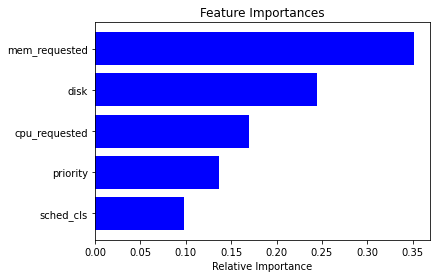

Index(['sched_cls', 'priority', 'cpu_requested', 'mem_requested', 'disk'], dtype='object')

time: 236 ms


In [11]:
feature_names = X_test.columns
plot_feature_importances(model.feature_importances_, feature_names)
feature_names

Memory and Disk are the most determining factors in producing a failure

# Hyperparameter tuning
You have three possibility:
* Manual tuning: 
  * Divide the training set in training subset and validation subset
  * Train different classifiers (with different hyperparameters) on the training subset
  * Check their performance, i.e., accuracy, on the validation subset
  * Choose the best
  * Test it on the test set
* `GridSearchCV` (as in `02.regression/b.polynomial-regression.ipynb`)
* `RandomizedSearchCV`

We use the latter now. See [Open Data Science post](https://medium.com/@ODSC/optimizing-hyperparameters-for-random-forest-algorithms-in-scikit-learn-d60b7aa07ead).

Let's first define the values of the parameters we want to explore

In [12]:
param_grid = {
    'criterion':['gini', 'entropy'],
    'max_features':[1,2,3,4,5],

    # Number of allowed leafs
    'max_leaf_nodes':[16, 32, 64, 128, 256, 512, 1024, 2048],

    # A node will be split if this split induces a decrease of the 
    # impurity greater than or equal to this value.
    'min_impurity_decrease' : [0, 0.001, 0.01, 0.1, 0.2],
            
    'max_depth':[1,10,100,1000,10000,100000],

    # A node can be a leaf only if it contains at least the following fraction
    # of samples
    'min_weight_fraction_leaf' : [0.1, 0.01, 0.001, 0]
    
}

time: 4.61 ms


We have a lot of possible configurations to check. We specify to just test 50
out of them.


In [13]:
# Before we had used all the availble CPUs for training one random forest.
# Now, instead, we use one CPU per random forest (n_jobs=1). 
forest = RandomForestClassifier(n_estimators=100, random_state = 4, n_jobs=1,)


search = RandomizedSearchCV(
                            scoring = 'accuracy', # See other possible metrics in
                                                # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                            
                            estimator=forest, 
                            param_distributions=param_grid,
                            n_iter=50, # We just test 50 configurations
                            verbose=2,random_state=42, 
                            n_jobs=-1, # Triain forests in parallel using 
                                      # all CPUs
                            cv=5 # 5-fold validation                      
                          )
# Note that we are training different random forests in parallel (n_jobs=-1),
# each with a certain combination of hyper-parameters.

search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 22.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

time: 22min 31s


{'min_weight_fraction_leaf': 0, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 64, 'max_features': 3, 'max_depth': 100000, 'criterion': 'entropy'}
Normalized confusion matrix
[[0.92827171 0.07172829]
 [0.0411923  0.9588077 ]]


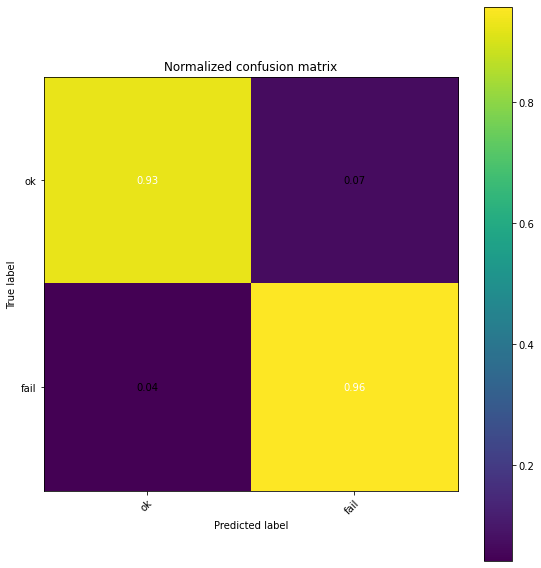

time: 815 ms


In [14]:
print(search.best_params_)

model = search.best_estimator_
y_pred = model.predict(X_test)

plot_conf_mat(y_test, y_pred, class_names)

Note that we get also get probabilities with RandomForests (fraction of trees that predicted `1`). And thus, we can compute cross-entropy

In [15]:
proba = model.predict_proba(X_test)
print("Output probabilities are ",proba)


print("Cross entropy = ", log_loss(y_test, proba))

Output probabilities are  [[9.99340277e-01 6.59723375e-04]
 [9.99371228e-01 6.28771823e-04]
 [5.73714441e-01 4.26285559e-01]
 ...
 [9.66755168e-01 3.32448319e-02]
 [1.75825657e-01 8.24174343e-01]
 [2.79366129e-02 9.72063387e-01]]
Cross entropy =  0.16287779685408652
time: 490 ms


Don't confuse cross-entropy with entropy of a tree node!

Since it may take some time to perform randomized search, let's save the model (**serializing** the python object)

In [16]:
filename = my_path+'forest-1.pkl'
pickle.dump(model, open(filename, 'wb'))

time: 3.37 s


To later retrieve it:



In [17]:
model = pickle.load(open(filename, 'rb'))

time: 12.3 ms


It is convenient to automate this process

In [18]:
def search_or_load(model_filename, search):
  if(isfile(model_filename) ):
    model = pickle.load(open(model_filename, 'rb'))

  else:
    search.fit(X_test, y_test)
    print(search.best_params_)
    model = search.best_estimator_
    pickle.dump(model, open(model_filename, 'wb'))

  return model


time: 4.05 ms


If we call this function, it will not redo the search, as the model has already been saved

In [19]:
model = search_or_load(filename, search)

time: 11.4 ms


### More iterations


Let's try to increase the number of tested configurations


In [ ]:
search = RandomizedSearchCV(
                            scoring = 'accuracy', # See other possible metrics in
                                                # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                            
                            estimator=forest, 
                            param_distributions=param_grid,
                            n_iter=200,
                            verbose=2,random_state=42, 
                            n_jobs=-1, # Triain forests in parallel using 
                                      # all CPUs
                            cv=5 # 5-fold validation                      
                          )

filename = my_path + 'forest-2.pkl'
model = search_or_load(filename, search)

time: 405 ms


Normalized confusion matrix
[[0.99632624 0.00367376]
 [0.25398468 0.74601532]]


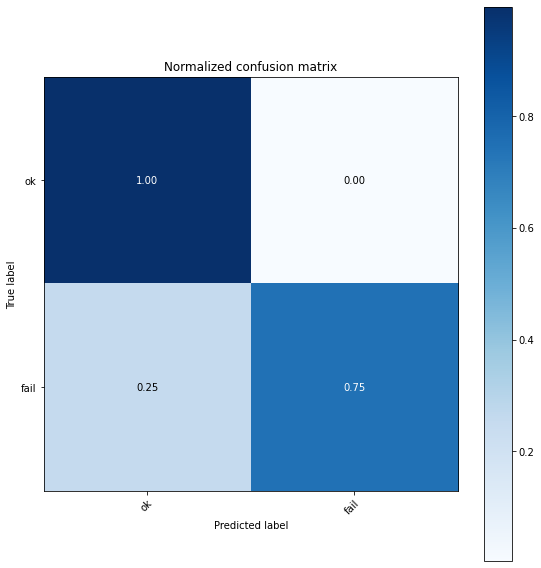

time: 894 ms


In [ ]:

y_pred = model.predict(X_test)

plot_conf_mat(y_test, y_pred, class_names)

It's better, but still bad. 

Ways to improve:
* Increase the number of trees
* Increase the number of configurations to try out

**Lesson learned**: before using Randomized Search, start with a single simple model.

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 64.1min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 101.2min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 147.8min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 202.9min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 253.6min finished


{'min_weight_fraction_leaf': 0, 'min_impurity_decrease': 0, 'max_leaf_nodes': 128, 'max_features': 3, 'max_depth': 1000, 'criterion': 'entropy'}
Normalized confusion matrix
[[0.99704659 0.00295341]
 [0.30117988 0.69882012]]


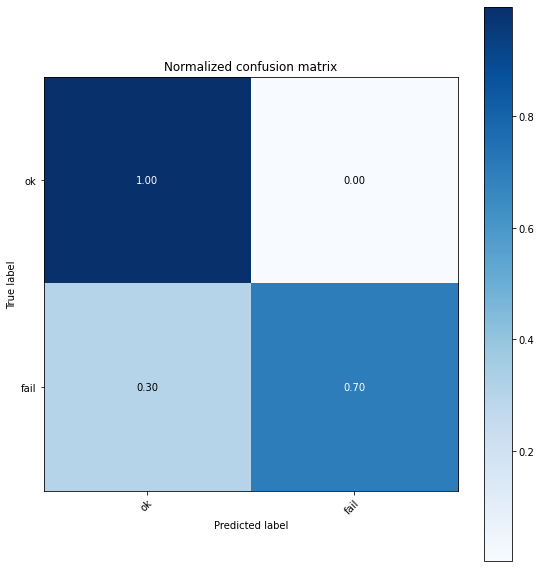

time: 4h 13min 52s


In [ ]:
forest = RandomForestClassifier(n_estimators=600, random_state = 4, n_jobs=1,)

search = RandomizedSearchCV(
                            scoring = 'accuracy', # See other possible metrics in
                                                # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                            
                            estimator=forest, 
                            param_distributions=param_grid,
                            n_iter=500,
                            verbose=2,random_state=42, 
                            n_jobs=-1, # Triain forests in parallel using 
                                      # all CPUs
                            cv=5 # 5-fold validation                      
                          )

filename = my_path + 'forest-3.pkl'
model = search_or_load(filename, search)
y_pred = model.predict(X_test)
plot_conf_mat(y_test, y_pred, class_names)

# References

[He16] Hemmat, R. A., & Hafid, A. (2016). SLA Violation Prediction In Cloud Computing: A Machine Learning Perspective. Retrieved from http://arxiv.org/abs/1611.10338

[Re11] Reiss, C., Wilkes, J., & Hellerstein, J. (2011). Google cluster-usage traces: format+ schema. Google Inc., …, 1–14. https://doi.org/10.1007/978-3-540-69057-3_88